# MATH50003 (2023–24)
# Lab 2: I.3 Dual Numbers and I.4 Newton's Method

In this lab we explore an alternative approach to computing derivatives:
using _dual numbers_. This is a special mathematical object akin to complex numbers
that allows us to compute derivatives to very high accuracy in an automated fashion,
i.e. an example of [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)
that is extremely important in Machine Learning and other computational applications.
To realise dual numbers on a computer we need to introduce the notation of a "type"
and create a customised type to represent dual numbers, which is what we discuss first.
As an application of computing derivatives we consider root finding via [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method).

**Learning Outcomes**

Mathematical knowledge:

1. Definition of dual numbers and functions applied dual numbers.
2. Approximating second derivatives using second-order divided differences.
3. Newton's method for root finding.

Coding knowledge:

1. The notion of a type and how to make your own type.
2. Defining functions whose arguments are restricted to specific types.
3. Overloading functions like `+`, `*`, and `exp` for a custom type.

We load the `Test` and `Plots` packages to be used below.
We also define the function `nanabs` which is useful for logarithmically scaled
plots. For brevity we use a shorthand `cond ? expr1 : expr2` which just means
```julia
if cond
    expr1
else
    expr2
end
```

In [76]:
using Plots, Test
nanabs(x) = x == 0 ? NaN : abs(x)

nanabs (generic function with 1 method)

## Types in Julia

Before we can use a concept like dual numbers we have to understand the notion of a "type".
In compiled languages like Julia everything has a "type". The function `typeof` can be used to determine the type of,
for example, a number.
By default when we write an integer (e.g. `-123`) it is of type `Int`:

In [77]:
typeof(5)

Int64

On a 64-bit machine this will print `Int64`, where the `64` indicates it is using precisely 64 bits
to represent the number (a topic we will come back to in Part II). If we write something with
a decimal point it represents a "real" number, whose storage is of type `Float64`:

In [78]:
typeof(5.3)

Float64

This is called a "floating point" number, and again the `64` indicates it is using precisely
64 bits to represent this number. (We will see this is why computations like divided differences
have large errors: because we are limiting the number of "digits" to represent numbers we need to
round our computations.) Note that some operations involving `Int`s return `Float64`s:

In [79]:
1/5 # 1 and 5 are Int but output is a Float64

0.2

It is possible to have functions behave differently depending on the input type.
To do so we can add a restriction denoted `::Int` or `::Float64` to the function "signature".
Here we create a function `foo` that is equal to `1` if the input is an `Int`, `0` if the input is
a `Float64`, and `-1` otherwise:

In [80]:
foo(x::Int) = 1 # The ::Int means this version is called when the input is an Int
foo(x::Float64) = 0
foo(x) = -1 # This is equivalent to f(x::Any) = -1

foo (generic function with 4 methods)

Anything that is not an Int or Float64 will call this

In [81]:
foo(3), foo(2.5), foo("hi"), foo(3.0)

(1, 0, -1, 0)

The last line returns a list of `Int`s, which has the type `Tuple`.
Note that there is a difference between an "integer" and the type `Int`: whilst 3.0 is an integer
its type is `Float64` so `foo(3.0) == 0`.

**Remark** Every type has a "supertype", which is an "abstract type": something you can't make an instance of it.
For example, in the same way that "integers"
are subsets of the "reals" we have that `Int` and `Float64` are subtypes of
`Real`. Which is a subtype of `Number`. Which, as is everything, a subtype of `Any`.

Types allow for combining multiple numbers (or instances of other types) to represent a more complicated
object. A simple example of this is a complex number,
which stores two real numbers $x$ and $y$ (either `Int` or `Float64` or indeed other real number types not yet discussed)
to represent the complex number $x + {\rm i} y$. In Julia ${\rm i} = \sqrt{-1}$ is denoted `im` and
hence we can create a complex number like $1+2{\rm i}$ as follows:

In [82]:
z = 1 + 2im

1 + 2im

This complex number has two "fields": the real and imaginary part. Accessing the fields is done
using a `.`, here we display the real and imaginary parts as a `Tuple`:

In [83]:
z.re, z.im

(1, 2)

When we ask  its type we see it is a `Complex{Int}`:

In [84]:
typeof(z)

Complex{Int64}

The `{Int}` indicates that each of the fields is an `Int`.
Note we can add, subtract, multiply, or apply functions like `exp` to complex numbers:

In [85]:
exp(2z^2 + 3im)

1.0970208521148807e-5 - 0.002478727901132598im

-----
**Problem 1(a)** Use `typeof` to determine the type of `1.2 + 2.3im`.

In [86]:
# TODO: What is the type of `1.2 + 2.3im`?
typeof(1.2 + 2.3im)

ComplexF64 (alias for Complex{Float64})

**Problem 1(b)** Add another implementation of `foo` that returns `im` if the input
is a `ComplexF64`.

In [87]:
# TODO: Overload foo for when the input is a ComplexF64 and return im
foo(x::ComplexF64) = im

@test foo(1.1 + 2im) == im

Test Passed

------

**Problem 2(a)** Consider the Taylor series approximation to the exponential:
$$
\exp z ≈ ∑_{k=0}^n {z^k \over k!}
$$
Complete the function `exp_t(z, n)` that computes this and returns a
`Complex{Float64}` if the input is complex and a `Float64` if the input is real.
Do not use the inbuilt `factorial` function.
Hint: It might help to think inductively: for $s_k = z^k/k!$ we have
$$
  s_{k+1}  = {z \over k+1} s_k.
$$

In [88]:
function exp_t(z, n)
    # TODO: Compute the first (n+1)-terms of the Taylor series of exp
    # evaluated at z

    sum = 1
    sk = z^0/1
    for k in 1:n
        sk *= z / k
        sum += sk
    end
    sum

end

@test exp_t(1.0, 10) isa Float64 # isa is used to test the type of a result
@test exp_t(im, 10) isa ComplexF64 # isa is used to test the type of a result

@test exp_t(1.0, 100) ≈ exp(1)

Test Passed

**Problem 2(b)** Plot the error for `n = 1:1000` of `exp_t(z, n)` for `z = 1, im, -5`, and `-100`,
scaling the y-axis logarithmically.
Does the method appear to converge for all values of $z$?

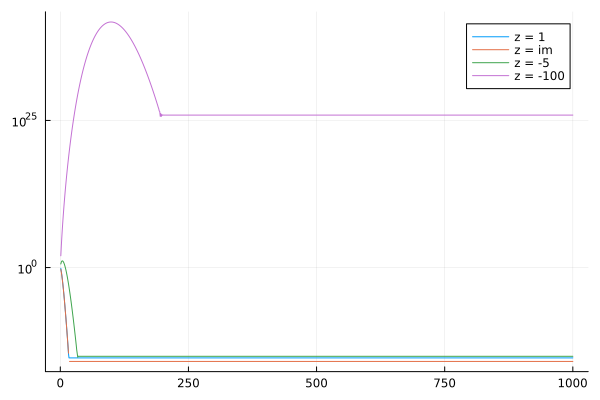

In [89]:
# TODO: plot the error for the Taylor series approximation.

err1 = [nanabs(exp_t(1, n) - exp(1)) for n = 1:1000]
err2 = [nanabs(exp_t(im, n) - exp(im)) for n = 1:1000]
err3 = [nanabs(exp_t(-5, n) - exp(-5)) for n = 1:1000]
err4 = [nanabs(exp_t(-100, n) - exp(-10)) for n = 1:1000]

plot(err1, yscale=:log10, label="z = 1")
plot!(err2, yscale=:log10, label="z = im")
plot!(err3, yscale=:log10, label="z = -5")
plot!(err4, yscale=:log10, label="z = -100")




------

One of the powerful parts of Julia is that it's very easy to make our own types. Lets begin with a simple
implementation of a rational function $p/q$ where $p$ and $q$ are `Int`s.  Thus we want to create a new
type called `Rat` with two fields `p` and `q` to represent the numerator and denominator, respectively.
(For simplicity  we won't worry about restricting $p$ and $q$ to be `Int`.)
We can construct such a type using the `struct` keyword:

In [90]:
struct Rat
    p
    q
end

A new instance of `Rat` is created via e.g. `Rat(1, 2)` represents 1/2
where the first argument specifies `p` and the second argument `q`.
The fields are accessed by `.`:

In [91]:
x = Rat(1, 2) # Rat(1, 2) creates an instance with fields equal to the input
@test x.p == 1
@test x.q == 2

Test Passed

Unfortunately we can't actually do anything with this type, yet:

In [92]:
x + x

Rat(4, 4)

The error is telling us to overload the `+` function when the inputs are both `Rat`.
To do this we need to "import" the `+` function and then we can overload it like any
other function:

In [93]:
import Base: + # allows us to overload +

# Here putting ::Rat after both x and y means this version of +
# is only called if both arguments are Rat
function +(x::Rat, y::Rat)
    p,q = x.p,x.q # x represents p/q
    r,s = y.p,y.q # y represents r/s
    Rat(p * s + r * q, q * s)
end

Rat(1,2) + Rat(3,4) # 1/2 + 3/4 == 10/8 (== 5/4) which is represented
                    # as Rat(10, 8)

Rat(10, 8)

We can support mixing `Rat` and `Int` by adding additional functionality:

In [94]:
Rat(p::Int) = Rat(p,1) # an Int is converted to p/1
+(x::Rat, y::Int) = x + Rat(y) # To add a Rat to an Int we convert the Int into a Rat and use the previously defined +

Rat(1,2) + 1  # 1 + 1/2 == 3/2

Rat(3, 2)

-----

**Problem 3** Support `*`, `-`, `/`, and `==` for `Rat` and `Int`.

In [95]:
# We import `+`, `-`, `*`, `/` so we can "overload" these operations
# specifically for `Rat`.
import Base: +, -, *, /, ==

# The ::Rat means the following version of `==` is only called if both
# arguments are Rat.
function ==(x::Rat, y::Rat)
    # TODO: implement equality, making sure to check the case where
    # the numerator/denominator are possibly reducible
    # Hint: gcd and div may be useful. Use ? to find out what they do

    xg = gcd(x.p, x.q)
    yg = gcd(y.p, y.q)
    div(x.p, xg) == div(y.p, yg) && div(x.q, xg) == div(y.q, yg)

end

# We can also support equality when `x isa Rat` and `y isa Int`
function ==(x::Rat, y::Int)
    # TODO: implement

    x == Rat(y)
    
end

# TODO: implement ==(x::Int, y::Rat)

function ==(x::Int, y::Rat)
    Rat(x) == y
end


@test Rat(1, 2) == Rat(2, 4)
@test Rat(1, 2) ≠ Rat(1, 3)
@test Rat(2,2) == 1
@test 1 == Rat(2,2)

# TODO: implement +, -, *, and /,

-(x::Rat, y::Rat) = Rat(x.p * y.q - y.p * x.q, x.q * y.q)
-(x::Rat, y::Int) = x - Rat(y)
-(x::Int, y::Rat) = Rat(x) - y

*(x::Rat, y::Rat) = Rat(x.p * y.p, x.q * y.q)
*(x::Rat, y::Int) = x * Rat(y)
*(x::Int, y::Rat) = Rat(x) * y

/(x::Rat, y::Rat) = Rat(x.p * y.q, x.q * y.p)
/(x::Rat, y::Int) = x / Rat(y)
/(x::Int, y::Rat) = Rat(x) / y



@test Rat(1, 2) + Rat(1, 3) == Rat(5, 6)
@test Rat(1, 3) - Rat(1, 2) == Rat(-1, 6)
@test Rat(2, 3) * Rat(3, 4) == Rat(1, 2)
@test Rat(2, 3) / Rat(3, 4) == Rat(8, 9)

Test Passed

------

## I.3 Dual Numbers

We now consider implementing a type `Dual` to represent the dual number $a + bϵ$,
in a way similar to `Complex` or `Rat`. For simplicity we don't restrict the types of `a` and `b`
but for us they will usually be `Float64`. We create this type very similar to `Rat` above:

In [96]:
struct Dual
    a
    b
end

We can easily support addition of dual numbers as in `Rat` using the formula
$$
(a+bϵ) + (c+dϵ) = (a+c) + (b+d)ϵ
$$

In [97]:
function +(x::Dual, y::Dual)
    a,b = x.a, x.b # x == a+bϵ. This gets out a and b
    c,d = y.a, y.b # y == c+dϵ. This gets out c and d
    Dual(a+c, b+d)
end
+(x::Dual, y::Real) = x + Dual(y, 0)
+(x::Real, y::Dual) = Dual(x, 0) + y

Dual(1,2) + Dual(3,4) # just adds each argument

Dual(4, 6)

For multiplication we used the fact that $ϵ^2 = 0$ to derive the formula
$$
(a+bϵ)*(c+dϵ) = ac +(bc+ad)ϵ.
$$
Here we support this operation by overloading `*` when the inputs are both
`Dual`:

In [98]:
import Base: * # we want to also overload *

function *(x::Dual, y::Dual)
    a,b = x.a, x.b # x == a+bϵ. This gets out a and b
    c,d = y.a, y.b # y == c+dϵ. This gets out c and d
    Dual(a*c, b*c + a*d)
end
*(x::Dual, y::Real) = x * Dual(y, 0)
*(x::Real, y::Dual) = Dual(x, 0) * y

* (generic function with 324 methods)

### I.3.1 Differentiating polynomials

Dual numbers allow us to differentiate functions provided they are composed of
operations overloaded for `Dual`. In particular, we have that
$$
f(x + b ϵ) = f(x) + bf'(x)ϵ
$$
and thus if we set `b = 1` the "dual part" is equal to the derivative.
We can use this fact to differentiate simple polynomials that only use `+`
and `*`:

In [99]:
f = x -> x*x*x + x
f(Dual(2,1)) # (2^3 + 2) + (3*2^2+1)*ϵ

Dual(10, 13)

A polynomial like `x^3 + 1` is not yet supported.
To support this we need to add addition of `Dual` with `Int` or `Float64`.
Note that both of these are "subtypes" of `Real` and so restricting on `Real`
will support both at the same time.
We can overload the appropriate functions as follows:

In [100]:
import Base: ^

Dual(a::Real) = Dual(a, 0) # converts a real number to a dual number with no ϵ

+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)

+ (generic function with 233 methods)

a simple recursive function to support x^2, x^3, etc.

In [101]:
function ^(x::Dual, n::Int)
    if n < 0
        error("Not implemented") # don't support negative n, yet
    end
    if n == 1
        x # Just return the input
    else
        ret = x
        for k = 1:n-1
            ret = ret*x
        end
        ret # returns the last argument
    end
end

f = x -> x^3 + 1
f(Dual(2,1))  # 2^3+1 + 3*2^2*ϵ

Dual(9, 12)

### I.3.2 Differentiating functions

We can also overload functions like `exp` so that they satisfy the rules of
a _dual extension_, that is, are consistent with the formula $f(a+bϵ) = f(a) + bf'(a)ϵ$
as follows:

In [102]:
import Base: exp
exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)

exp (generic function with 15 methods)

We can use this to differentiate a function that composes these basic operations:

In [104]:
f = x -> exp(x^2 + exp(x))
f(Dual(1, 1)).b

194.362805189629

What makes dual numbers so effective is that, unlike divided differences, they are not
prone to disasterous growth due to round-off errors: the above approximation
matches the true answer to roughly 16 digits of accuracy.

------

**Problem 4(a)** Add support for `-`, `cos`, `sin`, and `/` to the type `Dual`
by replacing the `# TODO`s in the below code.

In [106]:
import Base: -, cos, sin, /

# The following supports negation -(a+bϵ)
-(x::Dual) = Dual(-x.a, -x.b)

# TODO: implement -(::Dual, ::Dual)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
-(x::Dual, y::Real) = x - Dual(y)
-(x::Real, y::Dual) = Dual(x) - y

function cos(x::Dual)
    # TODO: implement cos for Duals

    Dual(cos(x.a), -x.b*sin(x.a))

end

function sin(x::Dual)
    # TODO: implement sin for Duals

    Dual(sin(x.a), x.b*cos(x.a))

end

function /(x::Dual, y::Dual)
    # TODO: implement division for Duals.
    # Hint: think of this as x * (1/y)
    if iszero(y.a)
        error("Division by zero")
    end
    Dual(x.a / y.a, (x.b * y.a - x.a * y.b) / y.a^2)
end
/(x::Dual, y::Real) = x / Dual(y, 0)
/(x::Real, y::Dual) = Dual(x, 0) / y

x = 0.1
ϵ = Dual(0,1)
@test cos(sin(x+ϵ)/(x+ϵ)).b ≈ -((cos(x)/x - sin(x)/x^2)sin(sin(x)/x))

Test Passed

**Problem 4(b)** Use dual numbers to compute the derivatives to
1. $\exp(\exp x \cos x + \sin x)$
2. $∏_{k=1}^{1000} \left({x \over k}-1\right)$
3. $f^{\rm s}_{1000}(x)$ where, as in Lab 1 Problem 3(d), $f^{\rm s}_n(x)$ corresponds to $n$-terms of the following continued fraction:
$$
1 + {x-1 \over 2 + {x-1 \over 2 + {x-1 \over 2 + ⋱}}}.
$$
at the point $x = 0.1$. Compare with divided differences to give evidence that your implementation is correct.

In [109]:
# TODO: Use dual numbers to compute the derivatives of the 3 functions above.
function f1(x)
    exp(exp(x) * cos(x) + sin(x))
end

function f2(x)
    prod = 1
    for k in 1:1000
        prod = prod * (x/k - 1)
    end
    prod
end

function f3(x)
    fn = 1 + (x - 1)/2
    for n in 1:1000
        fn = 1 + (x - 1)/(1 + fn)
    end
    fn
end

df1 = f1(Dual(0.1, 1)).b
df2 = f2(Dual(0.1, 1)).b
df3 = f3(Dual(0.1, 1)).b
print(
    df1, "\n",
    df2, "\n",
    df3)


6.5847725546108276
-3.593826513101571
1.5811388300841893

------
## I.4 Newton's method

Newton's method is a simple algorithmic approach that you may have seen before in school for computing roots (or zeros)
of functions. The basic idea is given an initial guess $x_0$,
find the first-order Taylor approximation $p(x)$ (i.e., find the line that matches the slope of the function at the point)
$$
f(x) ≈ \underbrace{f(x_0) + f'(x_0) (x- x_0)}_{p(x)}.
$$
We can then solve the root finding problem for $p(x)$ exactly:
$$
p(x) = 0 ⇔ x = x_0 - {f(x_0) \over f'(x_0)}
$$
We take this root of $p(x)$ as the new initial guess and repeat. In other words, we have a simple sequence
defined by
$$
x_{k+1} = x_k - {f(x_k) \over f'(x_k)}
$$
If the initial guess is "close enough" to a root $r$ of $f$ (ie $f(r) = 0$)
then it is known that $x_k → r$. Thus for large $N$ we have $x_N ≈ r$. Note the notion of "close enough"
is a complicated and rich theory beyond the scope of this module, and connects to the theory of [Mandelbrot sets](https://en.wikipedia.org/wiki/Mandelbrot_set).

Dual numbers as implemented by `Dual` gives us a powerful tool to compute derivatives and get a simple implementation
of Newton's method working:

In [110]:
# derivative(f, x) computes the derivative at a point x using Dual
derivative(f, x) = f(Dual(x,1)).b

function newton(f, x, N) # x = x_0 is the initial guess
    for k = 1:N
        x = x - f(x)/derivative(f,x)
    end
    x
end

f = x -> x^5 + x^2 + 1
r = newton(f, 0.1, 100)

-1.193859111321223

We can test that we have indeed found a root:

In [111]:
f(r)

6.661338147750939e-16

-----

**Problem 5(a)** For $f(x) = x^5 + x^2 + 1$, plot the error of $x_k$ for `k = 1:15` where the
y-axis is scaled logarithmically and chosen $x_0 = 0.1$ You may
use the computed `r` as the "exact" root. What do you think the convergence rate is?

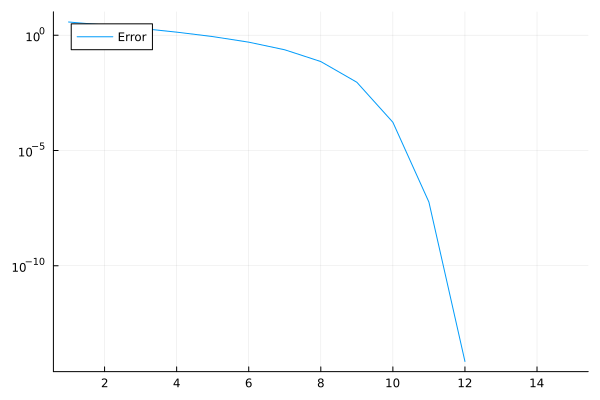

In [112]:
# TODO: compute and plot the error of `newton(f, 0.1, k)` for `k = 1:15`
err = [nanabs(newton(f, 0.1, k) - r) for k = 1:15]
plot(1:15, err, yscale=:log10, label="Error")
# converges faster than exponentially

**Problem 5(b)** Use `newton` with a complex number to compute
an approximation to a complex root of $f(x) = x^5 - x^2 + 1$.
Verify the approximation is accurate by testing that it satisfies $f(r)$
is approximately zero.

In [119]:
# TODO: By making the initial guess complex find a complex root.
r = newton(f, 0.1+0.1im, 100)
f(r)

0.0 + 5.551115123125783e-17im

**Problem 5(c)** By changing the initial guesses compute 5 roots to
$sin(x) - 1/x$. Hint: you may need to add an overload for `/(x::Real, y::Dual)`.

In [122]:
# TODO: Use `newton` to compute roots of `sin(x) - 1/x`.
g(x) = sin(x) - 1/x

newton(g, 1, 100),
newton(g, 2, 100),
newton(g, 3, 100),
newton(g, 4, 100),
newton(g, 5, 100),
newton(g, 6, 100)

(1.1141571408719302, -1.1141571408719302, 2.772604708265991, 2.772604708265991, 9.31724294141481, 6.439117238417246)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*